In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats as ss
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
import nibabel as nib
import func_plot as fp
import statsmodels.api as sm
import func_stats as fs
from brainspace.datasets import load_conte69
lh, rh = load_conte69()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
import hcp_utils as hcp
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

In [3]:
data = loadmat('../hcp/glasser_hcp_ind.mat')
intensity = data['glasser_hcp_ind'][0][0][0]

a = np.zeros(1206)
for i in range(1206):
  if intensity[i].mean() < 1:
    a[i] = 0
  else:
    a[i] = 1

mask_sub = a.copy()
all_1206 = pd.read_csv('../data/hcp1200_id_sex_age.csv')

intensity = intensity[mask_sub==1].mean(axis=1)
intensity.shape

(1101, 360)

In [4]:
ctx = loadmat('../hcp/hcp_ctx.mat')['CTX_fs32k']
ctx_mean = ctx[:,:32492].mean(1) - ctx[:,32492:].mean(1)

In [5]:
n_sub=intensity.shape[0]
lh_inten = intensity[:,:180].copy()
rh_inten = intensity[:,180:].copy()

lh_z = np.array([ss.zscore(lh_inten[n]) for n in range(n_sub)])
rh_z = np.array([ss.zscore(rh_inten[n]) for n in range(n_sub)])

mp = np.concatenate((lh_z,rh_z), axis=1)
mp.shape

(1101, 360)

In [6]:
# non-z but normalized by lh + rh

asy_total_nonz = (lh_inten - rh_inten) / (lh_inten + rh_inten)
asy_total_nonz.shape

(1101, 180)

In [7]:
asy_total = lh_z - rh_z
df = all_1206[mask_sub==1].reset_index().drop('index', axis=1)
for i in range(180):
  df['node_'+str(i+1)] = asy_total[:,i]
df.to_csv('../hcp/solar/intensity_asy_total/1_phen.csv', index=False)

In [8]:
a = []
for i in range(180):
  a.append(ss.ttest_1samp(asy_total[:,i],0))
cohen = np.array(a)[:,0]/pow(n_sub, 0.5)
df_total = pd.DataFrame(np.vstack((np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen)).T)
df_total.columns = ['t', 'p', 'p_fdr','cohen']
df_total.to_csv('../hcp/stat_hcp_intensity_asy_total_parcel.csv', index=None)
df_total

t              p          p_fdr     cohen
0   -33.227512  3.335406e-168  5.663897e-168 -1.001392
1   -34.653648  1.765074e-178  3.145677e-178 -1.044372
2   -42.792551  2.365082e-236  5.321435e-236 -1.289658
3   -38.750748  7.620911e-208  1.541308e-207 -1.167848
4   -42.642085  2.656235e-235  5.902744e-235 -1.285123
..         ...            ...            ...       ...
175  48.289625  4.871317e-274  1.486165e-273  1.455326
176  27.909893  4.817839e-130  7.226759e-130  0.841133
177  32.207160  7.542944e-161  1.245624e-160  0.970641
178  16.745278   3.077705e-56   3.847131e-56  0.504660
179   6.022359   2.340308e-09   2.537683e-09  0.181498

[180 rows x 4 columns]

In [9]:
ca_lh = np.zeros((n_sub,12)) # sub, ca
ca_rh = np.zeros((n_sub,12))
for i in range(n_sub):
  for n in range(12):
    ca_lh[i,n] = np.mean(lh_z[i][ca[:180]==n+1])
    ca_rh[i,n] = np.mean(rh_z[i][ca[180:]==n+1])
np.savetxt('../hcp/hcp_intensity_ca_LH.txt', ca_lh.mean(0))
np.savetxt('../hcp/hcp_intensity_ca_RH.txt', ca_rh.mean(0))

In [10]:
ca_asy = ca_lh - ca_rh
df = all_1206[mask_sub==1].reset_index().drop('index', axis=1)
for i in range(12):
  df['node_'+str(i+1)] = ca_asy[:,i]
df.to_csv('../hcp/solar/intensity_asy_total_ca/1_phen.csv', index=False)

In [11]:
glasser = np.genfromtxt('../data/glasser.csv')
glasser_l = glasser[:32492]
glasser_r = glasser[32492:]
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l,glasser_r))
mask = glasser != 0

In [12]:
ctx_360 = np.zeros((ctx.shape[0],360))
for i in range(360):
    ctx_360[:,i] = ctx[:,glasser==i+1].mean(1)

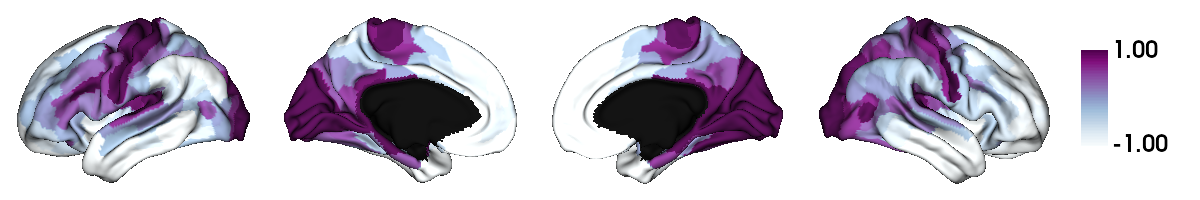

In [13]:
mask = glasser != 0
plot = map_to_labels(mp.mean(axis=0), glasser, mask=mask)
plot[plot==0]=np.nan
np.savetxt('../hcp/hcp_intensity_mean.txt', mp.mean(axis=0))

#from brainspace.datasets import load_fsa5
#lh, rh = load_fsa5()
fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/hcp/mean.png')

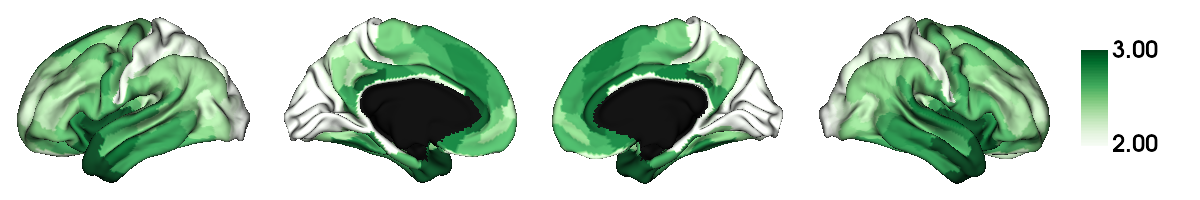

In [14]:
plot = map_to_labels(ctx_360.mean(axis=0), glasser, mask=mask)
plot[plot==0]=np.nan
np.savetxt('../hcp/hcp_ct_mean.txt', ctx_360.mean(axis=0))

#from brainspace.datasets import load_fsa5
#lh, rh = load_fsa5()
fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(2,3),
                   cmap = 'Greens', filename = '../figures/hcp/mean_ct.png')

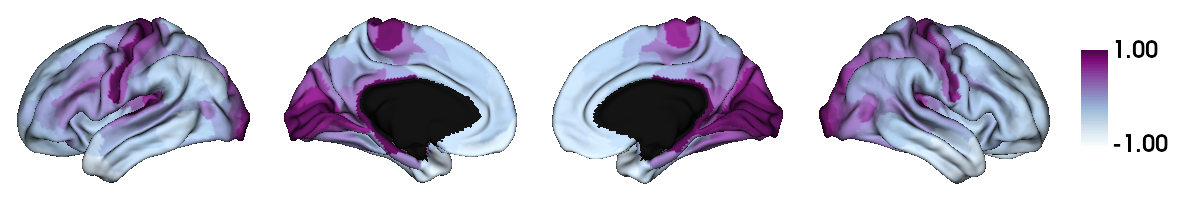

In [15]:
intenBYct = mp.mean(axis=0)/ctx_360.mean(axis=0)
plot = map_to_labels(intenBYct, glasser, mask=mask)
plot[plot==0]=np.nan
np.savetxt('../hcp/hcp_intensityBYct_mean.txt', intenBYct)

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/hcp/hcp_intensityBYct_mean.png')

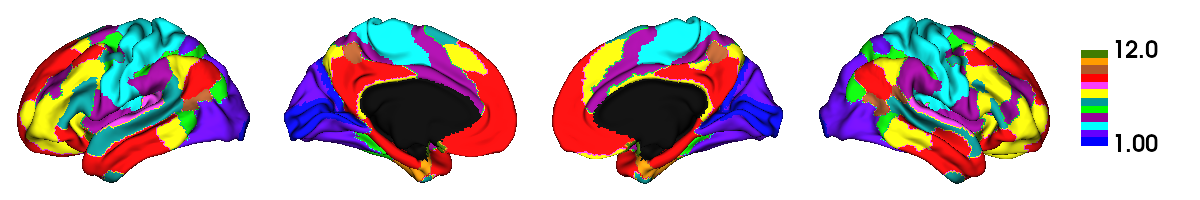

In [16]:
plot = map_to_labels(ca.astype(float), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(1,12),
                   cmap = cmap, filename = '../figures/hcp/ca_atlas.png')

In [17]:
a = []
for i in range(12):
  a.append(ss.ttest_1samp(ca_asy[:,i],0))
cohen_ca = np.array(a)[:,0]/pow(n_sub, 0.5)
df = pd.DataFrame(np.vstack((fp.network_name, np.array(a).T, fs.fdr(np.array(a)[:,1]), cohen_ca)).T)
df.columns = ['CA_label', 't', 'p', 'p_fdr','cohen_d']
df.to_csv('../hcp/stat_hcp_intensity_asy_total_ca.csv', index=None)
df.style.set_caption("asymetry VS 0 network-wise")

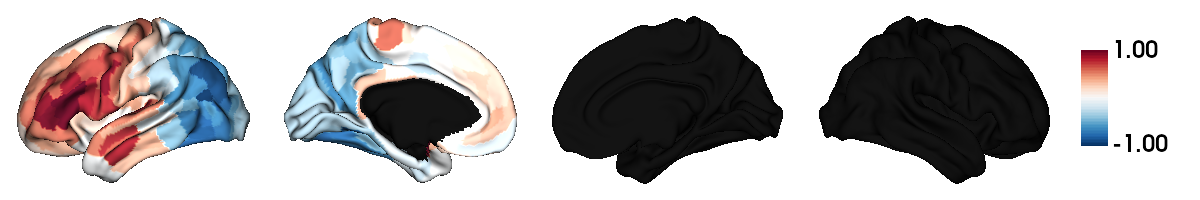

In [18]:
data = asy_total.mean(axis=0)
np.savetxt('../hcp/intensity_asy_mean.txt', data)
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'RdBu_r', filename = '../figures/hcp/mean_asy_overall.png')

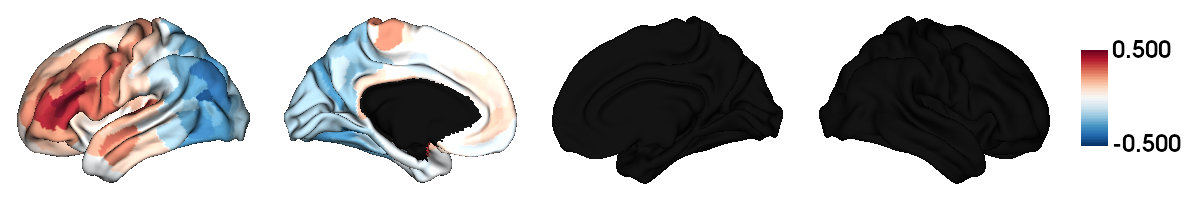

In [19]:
tmp = intenBYct[:180] - intenBYct[180:]
plot = map_to_labels(np.concatenate((tmp,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.5,0.5),
                   cmap = 'RdBu_r', filename = '../figures/hcp/mean_asy_overall_intenBYct.png')

In [20]:
rp = fs.spin_pearson(data, tmp)
rp

[PearsonRResult(statistic=0.9959188334775113, pvalue=7.085922568606415e-188),
 0.0]

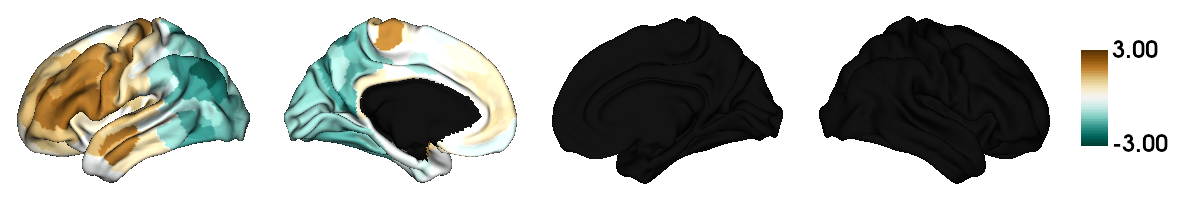

In [21]:
data = cohen.copy()
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-3,3),
                   cmap = 'BrBG_r', filename = '../figures/hcp/cohen_asy_overall.png')

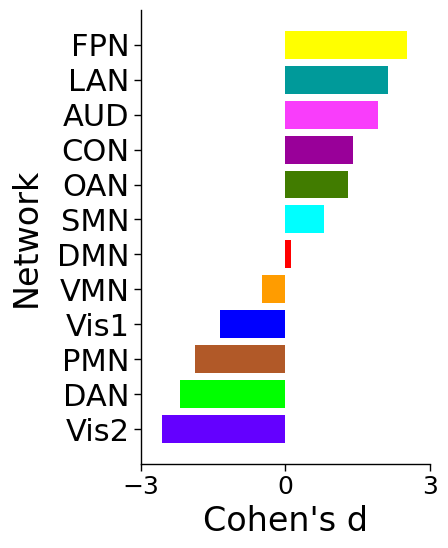

In [22]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(5,6))
fp.plot_t_single_h(cohen_ca, bar=None, ax=ax, thres=3, ascend=True,x_axis=True)
ax.set_ylabel('Network',labelpad=10)
ax.set_xlabel("Cohen's d")
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/ca_asy_cohen_bar.png', dpi=300, transparent=True)

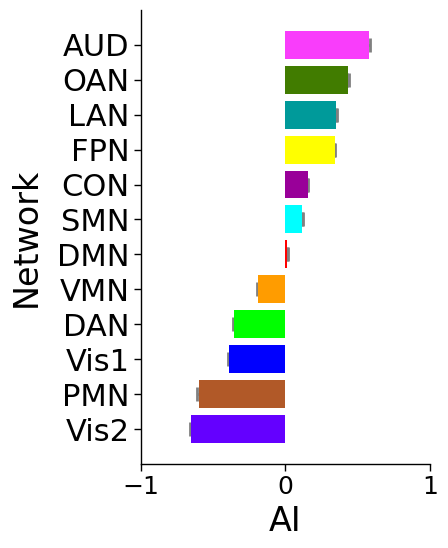

In [23]:
mean = ca_asy.mean(axis=0)
se = []
for i in range(12):
  se.append(fs.se(ca_asy[:,i]))
np.savetxt('../hcp/hcp_asy_ca.txt',mean)
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(5,6))
fp.plot_t_single_h(mean, bar=np.array(se), ax=ax, thres=1, ascend=True,x_axis=True)
ax.set_ylabel('Network',labelpad=10)
ax.set_xlabel('AI')
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/ca_asy_bar.png', dpi=300, transparent=True)

[PearsonRResult(statistic=0.4820185328508646, pvalue=7.334261738753286e-12),
 '=0.007']

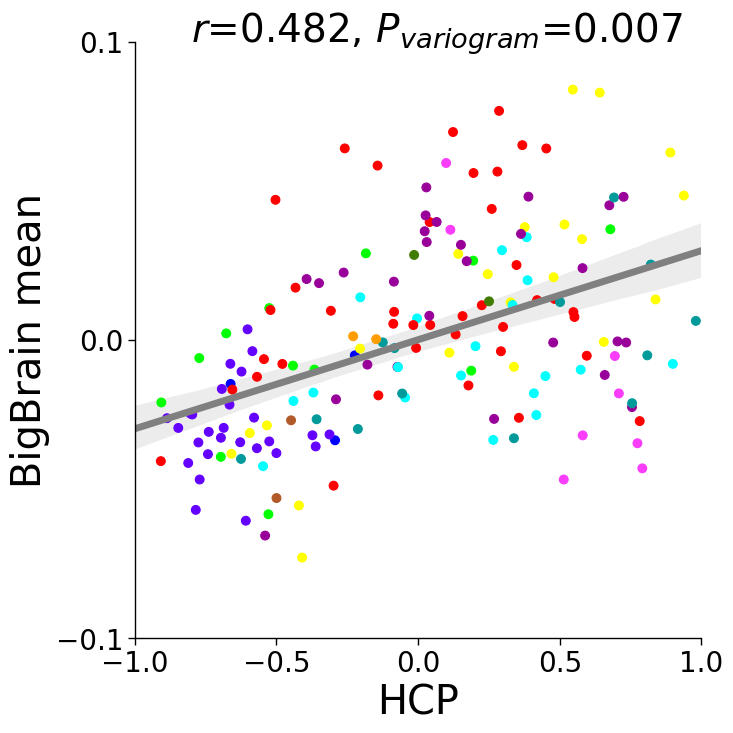

In [24]:
data = asy_total.mean(axis=0).copy()
bb_asy = np.loadtxt('../bigbrain/bigbrain_asy_mean.txt')
target = bb_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-1, 1)
ax.set_ylim(-0.1, 0.1)
ax.set_yticks([-0.1, 0, 0.1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('HCP')
ax.set_ylabel('BigBrain mean')
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_hcp_bb_asy_mean.png', dpi=300, transparent=True)
rp

In [25]:
rp = [None] * 6
r = np.zeros(6)
for i in range(6):
  target = np.loadtxt('../bigbrain/bigbrain_asy_layer_'+str(i+1)+'.txt')
  rp[i] = fs.spin_pearson(data, target)
rp

[[PearsonRResult(statistic=0.3070598679326751, pvalue=2.7567930988996428e-05),
  0.022],
 [PearsonRResult(statistic=0.19232444200529675, pvalue=0.009695070792490167),
  0.085],
 [PearsonRResult(statistic=0.5133926271701501, pvalue=1.7130358616945478e-13),
  0.0],
 [PearsonRResult(statistic=0.27435319186865015, pvalue=0.00019380229606148173),
  0.026],
 [PearsonRResult(statistic=0.048458923907526694, pvalue=0.5182826137382108),
  0.694],
 [PearsonRResult(statistic=0.02977141484258637, pvalue=0.6915660455949129),
  0.834]]

## Sex age effects

In [26]:
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
sex = FixedEffect(all_1206['Gender'][mask_sub==1], 'sex')
age = FixedEffect(all_1206['Age'][mask_sub==1], 'age')
sum(sex.sex_F)/n_sub, age.age.min(), age.age.max(),  age.age.mean(), age.age.std()

(0.5440508628519528, 22, 37, 28.821071752951863, 3.6954633964088406)

### handedness

In [27]:
handedness = pd.read_csv('../hcp/RESTRICTED_wanb_9_29_2020_2_14_36.csv')
hand = FixedEffect(handedness['Handedness'][mask_sub==1], 'hand')
hand.hand.min(), hand.hand.max(), hand.hand.mean(), hand.hand.std(), hand.hand[hand.hand>=0].shape, hand.hand[hand.hand<0].shape

(-100, 100, 65.99909173478656, 43.96866400349523, (1002,), (99,))

In [28]:
model = sex + age + hand
slm_hand = SLM(model, contrast=model.hand)
slm_hand.fit(asy_total)
t_hand = slm_hand.t[0]
p_hand = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_hand[i] = ss.t.sf(abs(t_hand[i]), dof) * 2
print(np.where(fs.fdr(p_hand)<0.05)[0])

[]


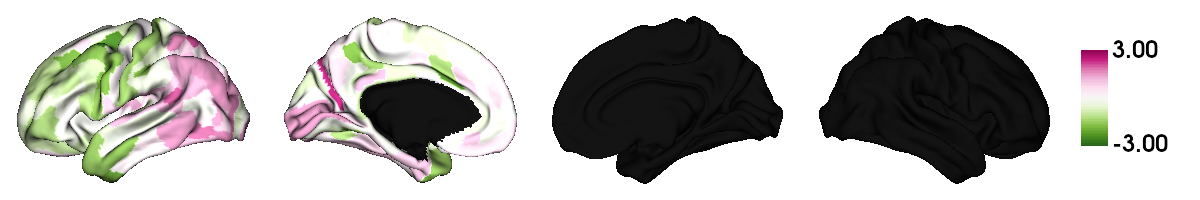

In [29]:
plot = t_hand.copy()
#plot[p_ctx>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-3,3),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_handedness.png')

### total cortical thickness

In [30]:
ctx_asy = FixedEffect(ctx_mean[mask_sub==1], 'ctx_asy')
ctx_asy.ctx_asy.min(), ctx_asy.ctx_asy.max(), ctx_asy.ctx_asy.mean(), ctx_asy.ctx_asy.std()

(-0.7582913833960043,
 0.11660266573222478,
 -0.03260038706424583,
 0.041714359870465685)

In [31]:
model = sex + age + ctx_asy
slm_ctx = SLM(model, contrast=model.ctx_asy)
slm_ctx.fit(asy_total)
t_ctx = slm_ctx.t[0]
p_ctx = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_ctx[i] = ss.t.sf(abs(t_ctx[i]), dof) * 2
print(np.where(fs.fdr(p_ctx)<0.05)[0])

[  7  23  25  43  56  57  58  59  60  62  68  69  97 108 123 153 162 172
 178 179]


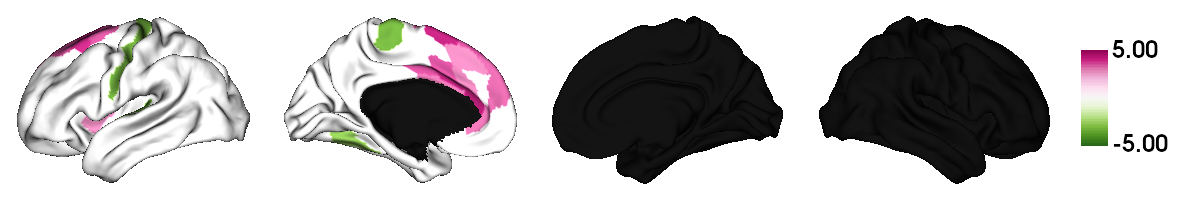

In [32]:
plot = t_ctx.copy()
plot[fs.fdr(p_ctx)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-5,5),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_thickness.png')

In [33]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(asy_total)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
print(np.where(fs.fdr(p_age_sex)<0.05)[0])

if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) < 5:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(asy_total)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(asy_total)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(180)
  p_age = np.zeros(180)
  dof = model.shape[0] - model.shape[1]
  for i in range(180):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2

np.savetxt('../hcp/hcp_sex_t.txt', t_sex)
np.savetxt('../hcp/hcp_sex_p.txt', p_sex)
np.savetxt('../hcp/hcp_sex_pfdr.txt', fs.fdr(p_sex))
np.savetxt('../hcp/hcp_age_t.txt', t_age)
np.savetxt('../hcp/hcp_age_p.txt', p_age)
np.savetxt('../hcp/hcp_age_pfdr.txt', fs.fdr(p_age))

[41 46]
no age*sex interaction


In [34]:
[dof, t_sex.min(), t_sex.max(), t_age.min(), t_age.max(),
 p_sex.min(), p_sex.max(), p_age.min(), p_age.max(),]

[1097,
 -11.539788317967098,
 12.223163782671973,
 -3.988472280755587,
 6.086970470947278,
 2.652544815883303e-32,
 0.9695374884407313,
 1.588433281021164e-09,
 0.9960388206736608]

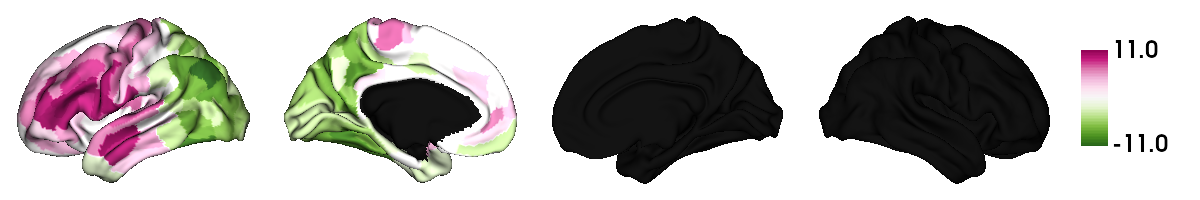

In [35]:
plot = t_sex.copy()
plot[fs.fdr(p_sex)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-11,11),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_sex.png')

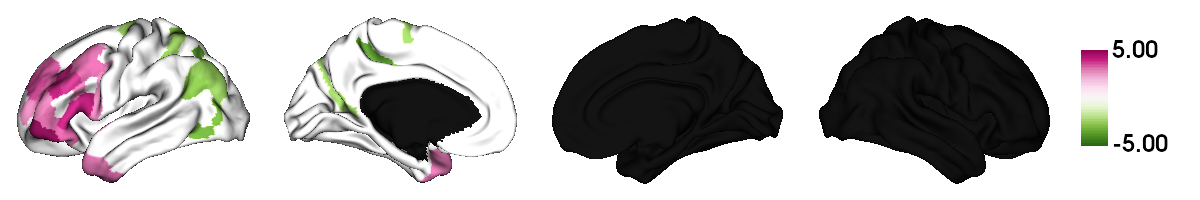

In [36]:
plot = t_age.copy()
plot[fs.fdr(p_age)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-5,5),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_age.png')

([PearsonRResult(statistic=0.961155230626598, pvalue=1.893607315449687e-101),
  '<0.001'],
 [PearsonRResult(statistic=0.6899903603087142, pvalue=8.886889021032312e-27),
  '<0.001'])

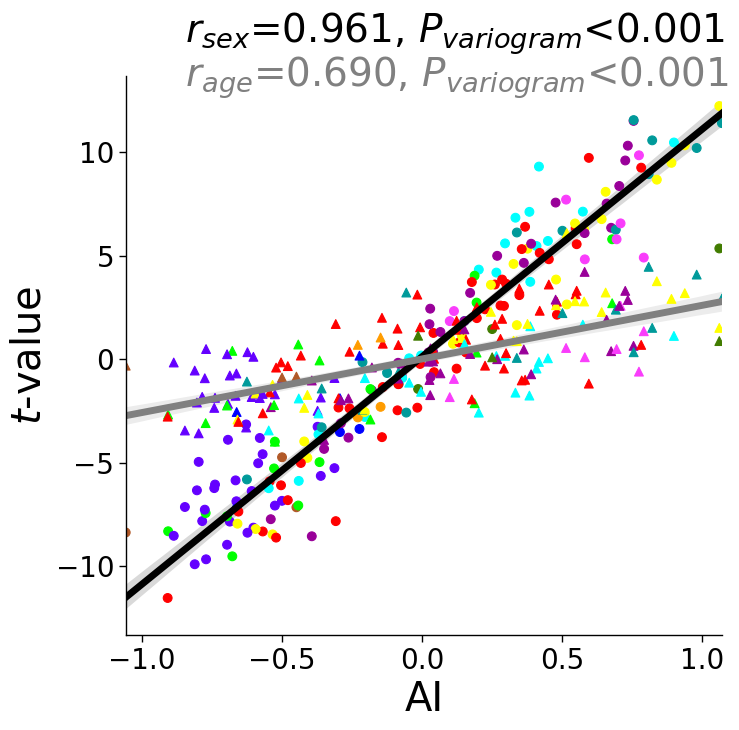

In [37]:
target1=t_sex.copy()
target2=t_age.copy()
rp1 = fs.spin_pearson(data, target1)
rp2 = fs.spin_pearson(data, target2)
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target1, ax = ax, 
            scatter_kws={'s': 0, 'color': 'red'},
            line_kws={'lw': 5, 'color': 'black'})
sns.regplot(data, target2, ax = ax, 
            scatter_kws={'s': 0, 'color': 'blue'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target1, c=ca[:180], cmap=cmap, s=40)
ax.scatter(data, target2, c=ca[:180], cmap=cmap, s=40, marker='^')
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(-0., 0.6)
#ax.set_ylim(-0.1, 0.1)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xlabel('AI')
ax.set_ylabel('$\it{t}$-value')
if rp1[1] == 0:
   rp1[1] = '<0.001'
else:
   rp1[1] = '=%.3f'%(rp1[1])
if rp2[1] == 0:
   rp2[1] = '<0.001'
else:
   rp2[1] = '=%.3f'%(rp2[1])
   
ax.text(0.1, 1.06, '$\it{r}$$_{sex}$=' + '%.3f'%(rp1[0][0])+', $\it{P}$$_{variogram}$'+rp1[1], 
        fontsize=28, c='black', transform=ax.transAxes)
ax.text(0.1, 0.98, '$\it{r}$$_{age}$=' + '%.3f'%(rp2[0][0])+', $\it{P}$$_{variogram}$'+rp2[1], 
        fontsize=28, c='grey', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_tmap_sex_age.png', dpi=300, transparent=True)
rp1, rp2

In [38]:
# non_zscore
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(asy_total_nonz)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(180)
dof = model.shape[0] - model.shape[1]
for i in range(180):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
print(np.where(fs.fdr(p_age_sex)<0.05)[0])

if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) < 50:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(asy_total_nonz)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(asy_total_nonz)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(180)
  p_age = np.zeros(180)
  dof = model.shape[0] - model.shape[1]
  for i in range(180):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2

np.savetxt('../hcp/hcp_sex_t_nonz.txt', t_sex)
np.savetxt('../hcp/hcp_sex_p_nonz.txt', p_sex)
np.savetxt('../hcp/hcp_sex_pfdr_nonz.txt', fs.fdr(p_sex))
np.savetxt('../hcp/hcp_age_t_nonz.txt', t_age)
np.savetxt('../hcp/hcp_age_p_nonz.txt', p_age)
np.savetxt('../hcp/hcp_age_pfdr_nonz.txt', fs.fdr(p_age))

[ 41  46  61  63  64  68  70  71  73  74  75  76  80  82  83  84  85  87
  88  89  90  93 105 107 108 109 110 111 112 130 169 170]
no age*sex interaction


In [39]:
[dof, t_sex.min(), t_sex.max(), t_age.min(), t_age.max(),
 p_sex.min(), p_sex.max(), p_age.min(), p_age.max(),]

[1097,
 -9.348935582014244,
 9.998035875700646,
 -4.185393918651025,
 5.684324555618114,
 1.3904004839060967e-22,
 0.8294275145170661,
 1.682429454080719e-08,
 0.9934926007407167]

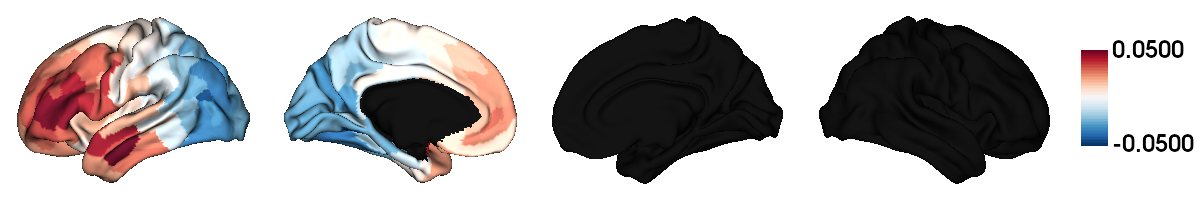

In [40]:
plot = asy_total_nonz.mean(0)
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.05,0.05),
                   cmap = 'RdBu_r', filename = '../figures/hcp/asy_mean_nonz.png')

In [84]:
fs.spin_pearson(asy_total_nonz.mean(0), asy_total.mean(0))

[PearsonRResult(statistic=0.9359302249822563, pvalue=1.3485084987938468e-82),
 0.0]

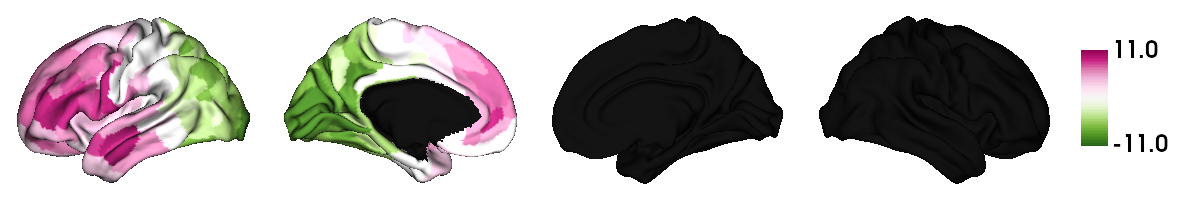

In [41]:
plot = t_sex.copy()
plot[fs.fdr(p_sex)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-11,11),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_sex_nonz.png')

In [82]:
fs.spin_pearson(np.loadtxt('../hcp/hcp_sex_t_nonz.txt'), 
                np.loadtxt('../hcp/hcp_sex_t.txt'))

[PearsonRResult(statistic=0.918107203187353, pvalue=1.8506820985149775e-73),
 0.0]

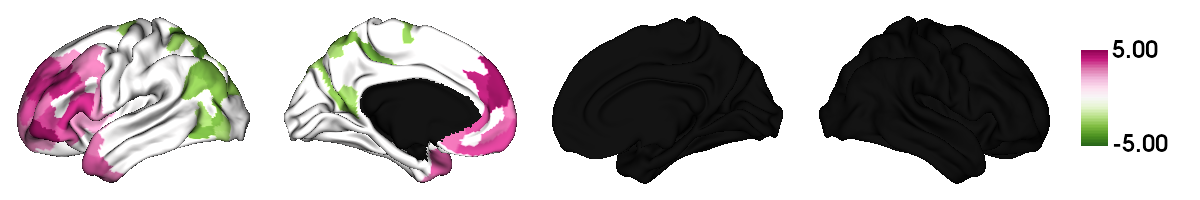

In [42]:
plot = t_age.copy()
plot[fs.fdr(p_age)>0.05] = np.inf
plot = map_to_labels(np.concatenate((plot,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf] = 0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-5,5),
                   cmap = 'PiYG_r', filename = '../figures/hcp/asy_tmap_age_nonz.png')

In [83]:
fs.spin_pearson(np.loadtxt('../hcp/hcp_age_t_nonz.txt'), 
                np.loadtxt('../hcp/hcp_age_t.txt'))

[PearsonRResult(statistic=0.9338760717279095, pvalue=2.039605796627781e-81),
 0.0]

In [43]:
model = sex + age + sex*age
slm_age_sex = SLM(model, contrast=model.matrix['sex_M*age'])
slm_age_sex.fit(ca_asy)
t_age_sex = slm_age_sex.t[0]
p_age_sex = np.zeros(12)
dof = model.shape[0] - model.shape[1]
for i in range(12):
  p_age_sex[i] = ss.t.sf(abs(t_age_sex[i]), dof) * 2
print(np.where(fs.fdr(p_age_sex)<0.05)[0])

if len(np.where(fs.fdr(p_age_sex)<0.05)[0]) < 2:
  print('no age*sex interaction')
  model = sex + age
  slm_sex = SLM(model, contrast=model.sex_M)
  slm_sex.fit(ca_asy)
  slm_age = SLM(model, contrast=model.age)
  slm_age.fit(ca_asy)
  t_sex = slm_sex.t[0]
  t_age = slm_age.t[0]
  p_sex = np.zeros(12)
  p_age = np.zeros(12)
  dof = model.shape[0] - model.shape[1]
  for i in range(12):
    p_sex[i] = ss.t.sf(abs(t_sex[i]), dof) * 2
    p_age[i] = ss.t.sf(abs(t_age[i]), dof) * 2

np.savetxt('../hcp/hcp_sex_t_ca.txt', t_sex)
np.savetxt('../hcp/hcp_sex_p_ca.txt', p_sex)
np.savetxt('../hcp/hcp_sex_pfdr_ca.txt', fs.fdr(p_sex))
np.savetxt('../hcp/hcp_age_t_ca.txt', t_age)
np.savetxt('../hcp/hcp_age_p_ca.txt', p_age)
np.savetxt('../hcp/hcp_age_pfdr_ca.txt', fs.fdr(p_age))

[]
no age*sex interaction


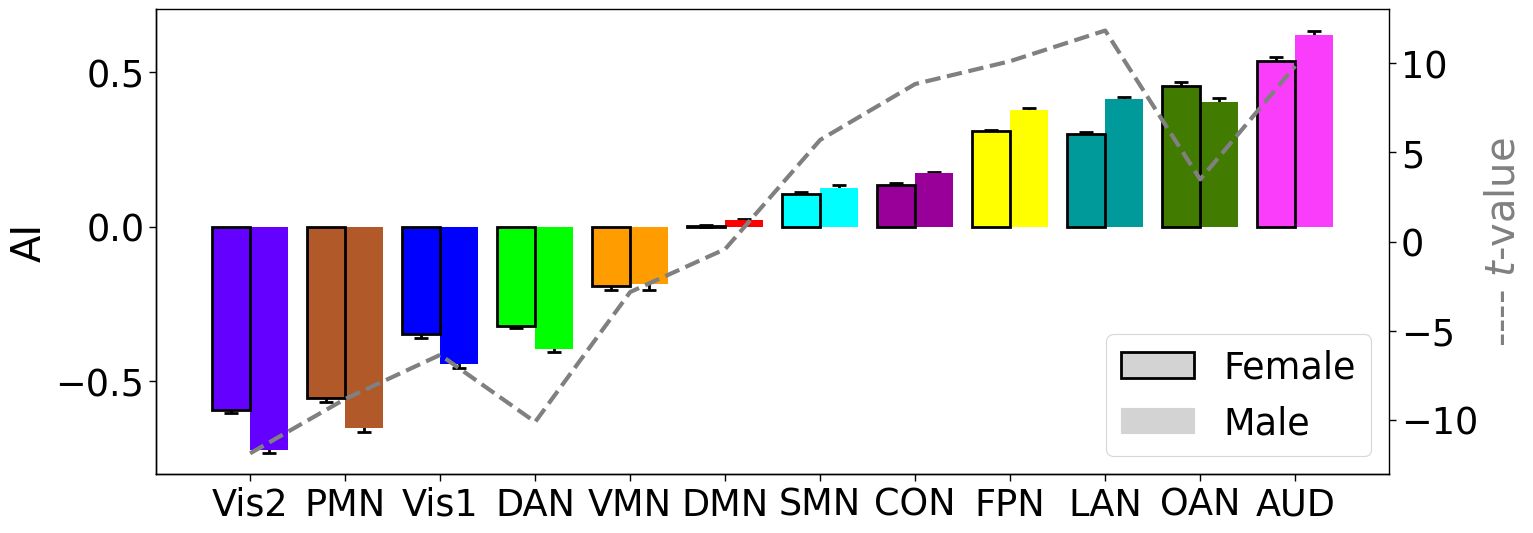

In [44]:
rank=ca_asy.mean(0).argsort()
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(16,6))
se_F = [fs.se(ca_asy[model.sex_F==1][:,i]) for i in range(12)]
se_M = [fs.se(ca_asy[model.sex_M==1][:,i]) for i in range(12)]
ax.bar(np.arange(12)-0.2,ca_asy[model.sex_F==1].mean(0)[rank], width=0.4, linewidth=2,
       yerr=np.array(se_F)[rank], color=fp.c_color[rank], edgecolor='black', zorder=2, label='Female',
       error_kw=dict(ecolor='black', zorder=0, lw=2, capsize=5, capthick=2))
ax.bar(np.arange(12)+0.2,ca_asy[model.sex_M==1].mean(0)[rank], width=0.4, 
       yerr=np.array(se_M)[rank], color=fp.c_color[rank], label='Male',
       error_kw=dict(ecolor='black', zorder=0, lw=2, capsize=5, capthick=2))

ax.set_xticks(np.arange(12))
ax.set_yticks([-0.5,0,0.5])
ax.set_ylabel('AI')
ax.set_xticklabels(fp.network_name[rank])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='lower right')
leg = ax.get_legend()
leg.legendHandles[0].set_color('lightgray')
leg.legendHandles[0].set_edgecolor('black')
leg.legendHandles[1].set_color('lightgray')

ax2=ax.twinx()
ax2.plot(np.arange(12),t_sex[rank], color='gray', lw=3, ls='--')
ax2.set_ylabel('---- $\it{t}$-value', color='gray')

fig.tight_layout()
plt.savefig('../figures/hcp/corr_tmap_sex.png', dpi=300, transparent=True)

In [45]:
model.age[model.age>28].shape, model.age[model.age<29].shape

((585,), (516,))

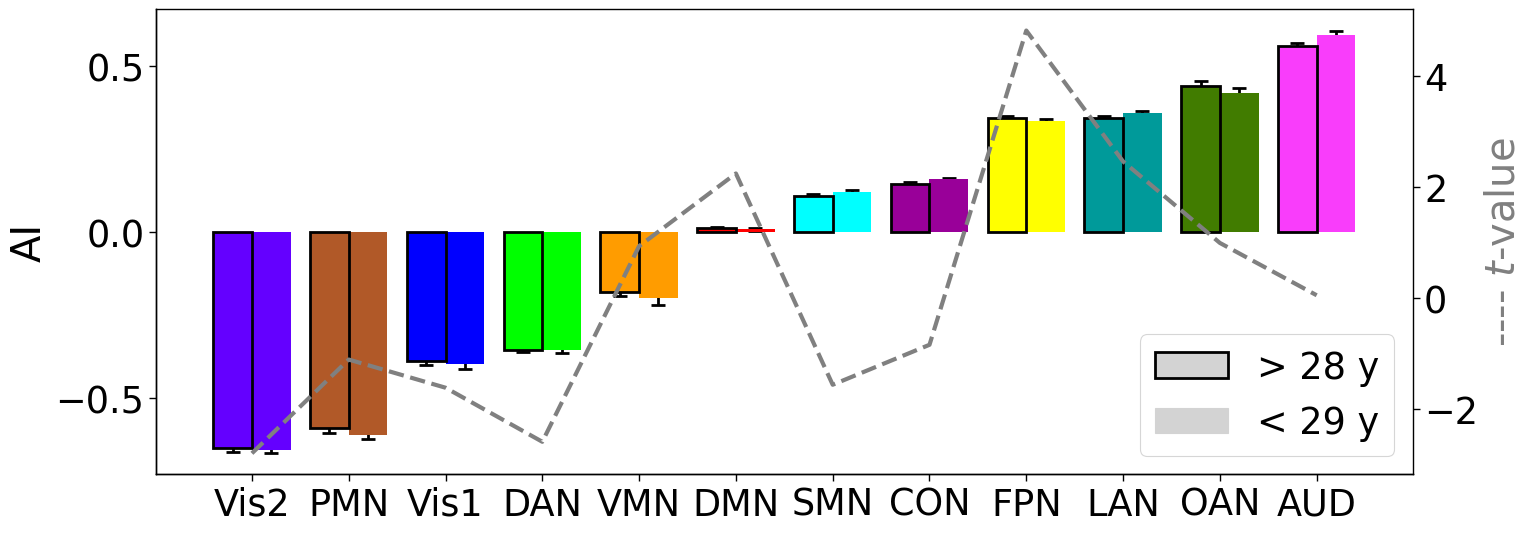

In [46]:
rank=ca_asy.mean(0).argsort()
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(16,6))
se_H = [fs.se(ca_asy[model.age>28][:,i]) for i in range(12)]
se_L = [fs.se(ca_asy[model.age<29][:,i]) for i in range(12)]
ax.bar(np.arange(12)-0.2,ca_asy[model.age>28].mean(0)[rank], width=0.4, linewidth=2,
       yerr=np.array(se_F)[rank], color=fp.c_color[rank], edgecolor='black', zorder=2, label='> 28 y',
       error_kw=dict(ecolor='black', zorder=0, lw=2, capsize=5, capthick=2))
ax.bar(np.arange(12)+0.2,ca_asy[model.age<29].mean(0)[rank], width=0.4, 
       yerr=np.array(se_M)[rank], color=fp.c_color[rank], label='< 29 y',
       error_kw=dict(ecolor='black', zorder=0, lw=2, capsize=5, capthick=2))

ax.set_xticks(np.arange(12))
ax.set_yticks([-0.5,0,0.5])
ax.set_ylabel('AI')
ax.set_xticklabels(fp.network_name[rank])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='lower right')
leg = ax.get_legend()
leg.legendHandles[0].set_color('lightgray')
leg.legendHandles[0].set_edgecolor('black')
leg.legendHandles[1].set_color('lightgray')

ax2=ax.twinx()
ax2.plot(np.arange(12),t_age[rank], color='gray', lw=3, ls='--')
ax2.set_ylabel('---- $\it{t}$-value', color='gray')

fig.tight_layout()
plt.savefig('../figures/hcp/corr_tmap_age.png', dpi=300, transparent=True)

In [47]:
t_sex.round(3)[rank], fs.fdr(p_sex).round(3)[rank], t_age.round(3)[rank], fs.fdr(p_age).round(3)[rank]

(array([-11.884,  -8.833,  -6.359, -10.125,  -2.834,  -0.422,   5.704,
          8.839,  10.12 ,  11.839,   3.485,   9.848]),
 array([0.   , 0.   , 0.   , 0.   , 0.005, 0.673, 0.   , 0.   , 0.   ,
        0.   , 0.001, 0.   ]),
 array([-2.797, -1.106, -1.614, -2.589,  0.939,  2.248, -1.56 , -0.84 ,
         4.826,  2.465,  0.996,  0.053]),
 array([0.031, 0.403, 0.214, 0.039, 0.418, 0.059, 0.204, 0.438, 0.   ,
        0.042, 0.426, 0.958]))

## Heritability

index  node             name       H2r        SE            rp
0       0     1   ./node_1_INORM  0.352401  0.055840  7.977988e-11
1       2     2   ./node_2_INORM  0.513877  0.051210  1.547338e-18
2       1     3   ./node_3_INORM  0.291148  0.051800  9.799119e-09
3       6     4   ./node_4_INORM  0.267640  0.058681  2.000000e-06
4       3     5   ./node_5_INORM  0.432286  0.052794  2.303272e-14
5      11     6   ./node_6_INORM  0.225518  0.055237  1.930000e-05
6       9     7   ./node_7_INORM  0.390430  0.059360  1.085304e-10
7       7     8   ./node_8_INORM  0.304313  0.057655  1.000000e-07
8       5     9   ./node_9_INORM  0.277319  0.054739  2.000000e-07
9       8    10  ./node_10_INORM  0.337223  0.057040  2.297226e-09
10     10    11  ./node_11_INORM  0.112022  0.057432  2.268420e-02
11      4    12  ./node_12_INORM  0.230020  0.055427  1.170000e-05

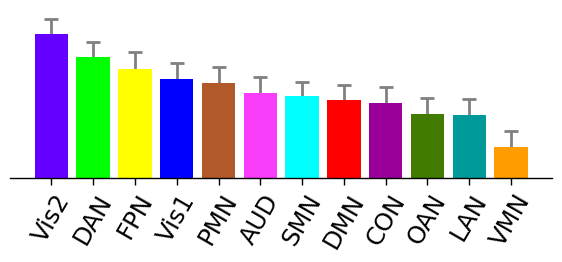

In [48]:
h2_parcel = pd.read_csv('../hcp/solar/intensity_asy_total/1_heri_result.csv').sort_values(by=['node']).reset_index()
h2_ca = pd.read_csv('../hcp/solar/intensity_asy_total_ca/1_heri_result.csv').sort_values(by=['node']).reset_index()

sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(6,3))
fp.plot_t_single(h2_ca['H2r'], bar=h2_ca['SE'], ax=ax, x_rota=60, thres=0.6, ascend=False)
fig.tight_layout()
fig.savefig('../figures/hcp/inten_asy_h2r.png', dpi=300, transparent=True)
h2_ca

In [49]:
fs.fdr(h2_ca['rp'])

0     3.191195e-10
1     1.856805e-17
2     1.959824e-08
3     2.666667e-06
4     1.381963e-13
5     2.105455e-05
6     3.255913e-10
7     1.714286e-07
8     3.000000e-07
9     5.513342e-09
10    2.268420e-02
11    1.404000e-05
Name: rp, dtype: float64

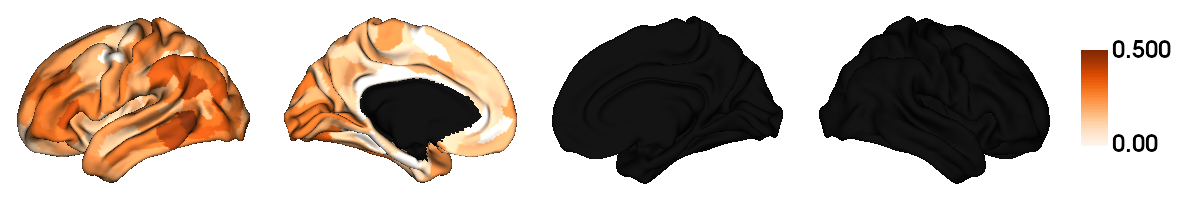

In [50]:
data = np.array(h2_parcel['H2r'])
data[fs.fdr(h2_parcel['rp'])>0.05] = np.inf
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==np.inf]=0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(0,0.5),
                   cmap = 'Oranges', filename = '../figures/hcp/inten_asy_h2r_parcel.png')

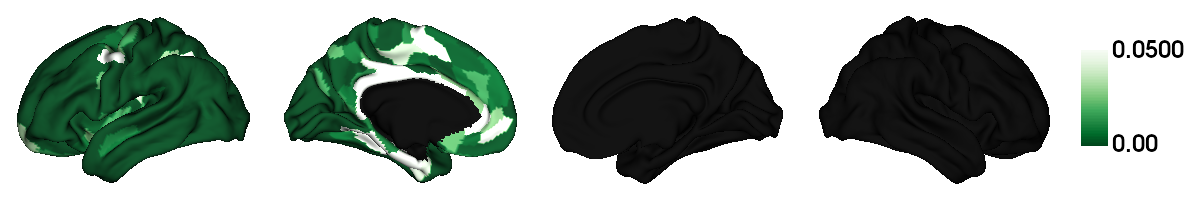

In [51]:
data = fs.fdr(np.array(h2_parcel['rp']))
#data[data>0.05] = 10
plot = map_to_labels(np.concatenate((data,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
plot[plot==10]=0

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(0,0.05),
                   cmap = 'Greens_r', filename = '../figures/hcp/inten_asy_h2r_fdr_parcel.png')

[PearsonRResult(statistic=0.46878995297444975, pvalue=3.199405195657894e-11),
 '=0.001']

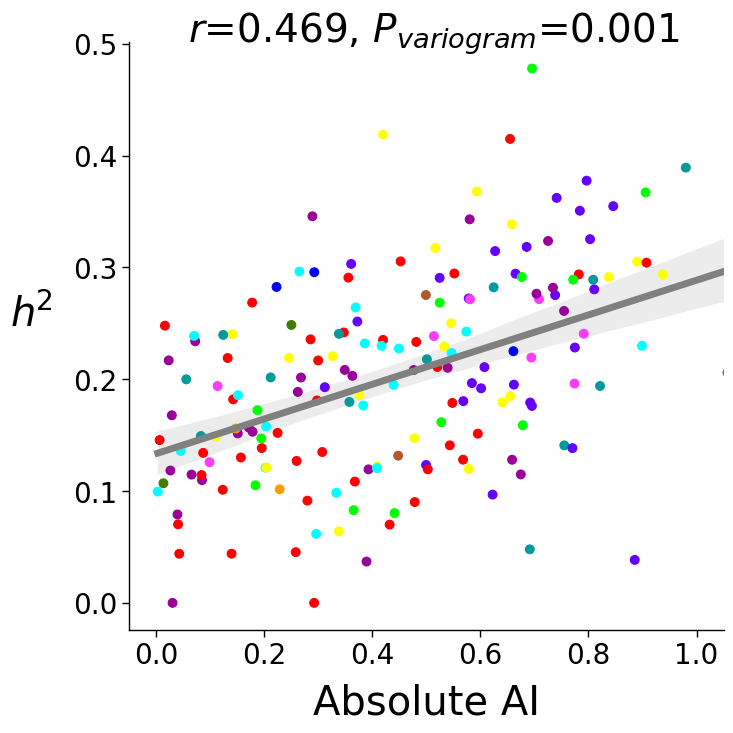

In [52]:
rp = fs.spin_pearson(np.array(h2_parcel['H2r']), abs(asy_total.mean(axis=0)))
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(abs(asy_total.mean(axis=0)), h2_parcel['H2r'], ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(abs(asy_total.mean(axis=0)), h2_parcel['H2r'],c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-0.05, 1.05)
ax.set_xlabel('Absolute AI', labelpad=10)
ax.set_ylabel('$\it{h}$$^2$', labelpad=30, rotation=0)
if rp[1] == 0:
   rp[1] = '<0.001'
else:
   rp[1] = '=%.3f'%(rp[1])
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$'+rp[1], 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_intenAsy_h2r.png', dpi=300, transparent=True)
rp

# structure-Function

## Group level

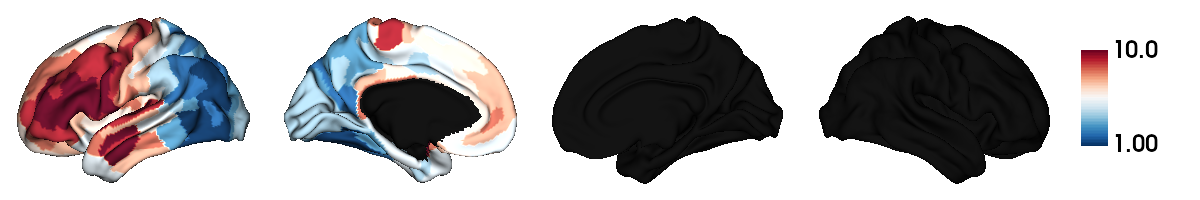

In [53]:
data = asy_total.mean(axis=0)
bin=10
plot = ss.rankdata(data)-1
for i in range(bin):
  plot[np.logical_and(plot>=i*int(180/bin), plot < i*int(180/bin)+int(180/bin))] = i+1
plot_bin=plot.copy()
plot = map_to_labels(np.concatenate((plot_bin,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(1,bin),
                   cmap = 'RdBu_r', filename = '../figures/hcp/mean_asy_overall_bin.png')

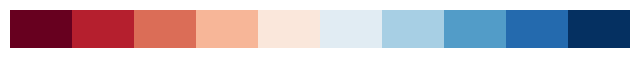

In [54]:
gradient = np.linspace(0, 1, 10)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(8,0.5))
ax = fig.add_subplot(111)
ax.imshow(gradient, aspect='auto', cmap='RdBu')
ax.set_axis_off()
fig.tight_layout()
fig.savefig('../figures/colorbar/RdBu_10bin.png', dpi=300, transparent=True)  

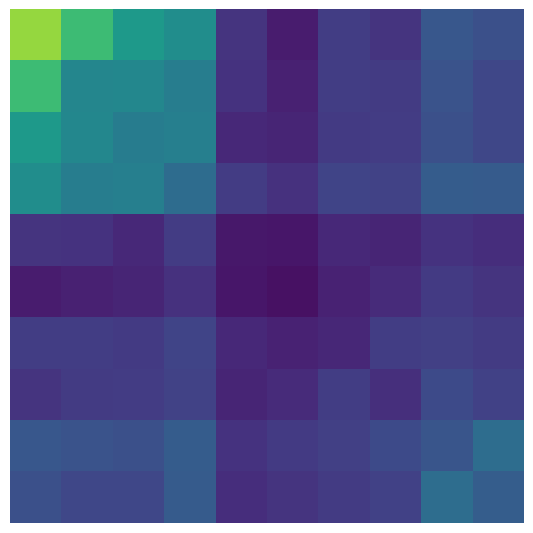

In [55]:
fc_LL = np.loadtxt('../hcp/func/FC/LL_groupmean.csv',delimiter=',')
fc_LL_rank = fc_LL[data.argsort()][:,data.argsort()]
bin=10
fc_LL_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_LL_bin[i,j] = fc_LL_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_LL_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_LL_rankedbyai.png', dpi=300, transparent=True)

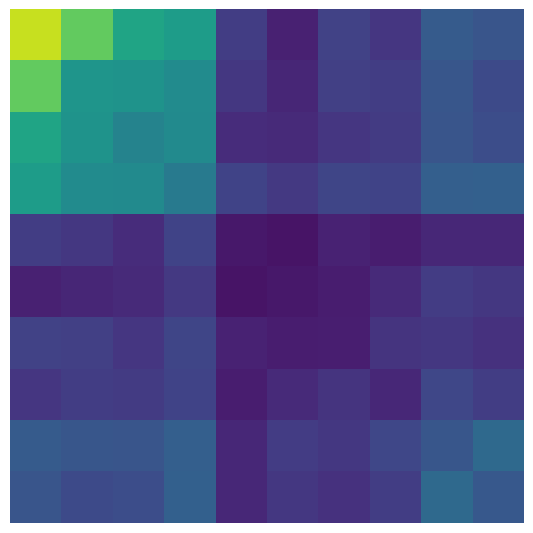

In [56]:
fc_RR = np.loadtxt('../hcp/func/FC/RR_groupmean.csv',delimiter=',')
fc_RR_rank = fc_RR[data.argsort()][:,data.argsort()]
bin=10
fc_RR_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_RR_bin[i,j] = fc_RR_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_RR_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_RR_rankedbyai.png', dpi=300, transparent=True)

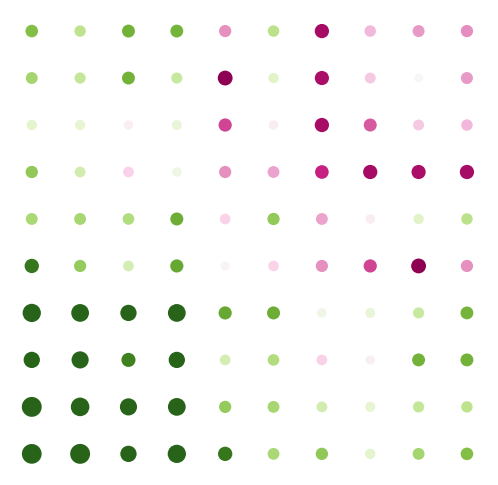

In [57]:
fc_asy_bins = (fc_LL_bin - fc_RR_bin)#/(fc_LL_bin + fc_RR_bin)
df=pd.DataFrame()
matrix = np.arange(0, 100).reshape((10, 10)) % 10
df['x'] = matrix.flatten()
df['y'] = matrix.T.flatten()
df['color'] = fc_asy_bins.flatten()
df['size'] = abs(fc_asy_bins).flatten()
sns.relplot(data=df, x='x', y='y',hue='color', size='size', palette="PiYG_r",
            sizes=(40, 400), linewidth=0, legend=False,
            hue_norm=(-0.01, 0.01), size_norm=(0, 0.05),
            aspect=1, height=6)
plt.axis('off')
#plt.tight_layout()
plt.savefig('../figures/hcp/fc_intra_rankedbyai.png', dpi=300, transparent=True)

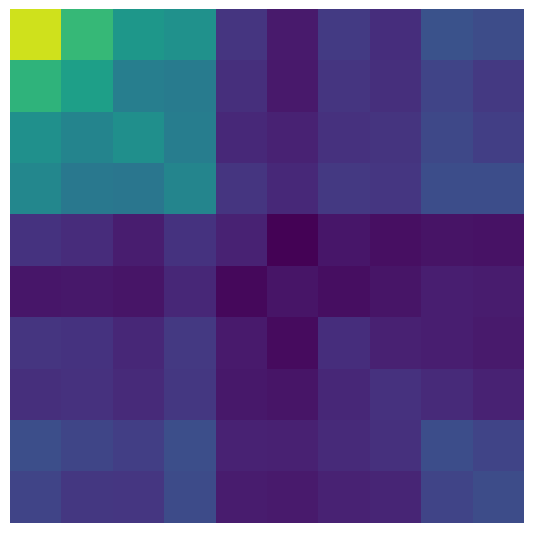

In [58]:
fc_LR = np.loadtxt('../hcp/func/FC/LR_groupmean.csv',delimiter=',')
fc_LR_rank = fc_LR[data.argsort()][:,data.argsort()]
bin=10
fc_LR_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_LR_bin[i,j] = fc_LR_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_LR_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_LR_rankedbyai.png', dpi=300, transparent=True)

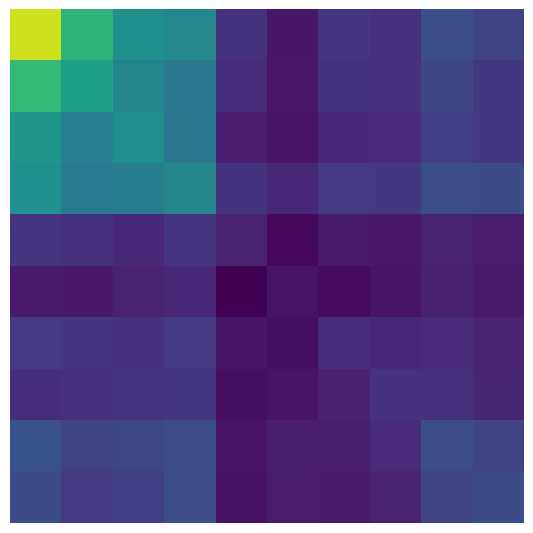

In [59]:
fc_RL = np.loadtxt('../hcp/func/FC/RL_groupmean.csv',delimiter=',')
fc_RL_rank = fc_RL[data.argsort()][:,data.argsort()]
bin=10
fc_RL_bin = np.zeros((bin,bin))
for i in range(bin):
    for j in range(bin):
       fc_RL_bin[i,j] = fc_RL_rank[i*int(180/bin):i*int(180/bin)+int(180/bin), j*int(180/bin):j*int(180/bin)+int(180/bin)].mean(axis=None)

fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(fc_RL_bin, cmap='viridis', vmax=0.4, vmin=0.1)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/fc_RL_rankedbyai.png', dpi=300, transparent=True)

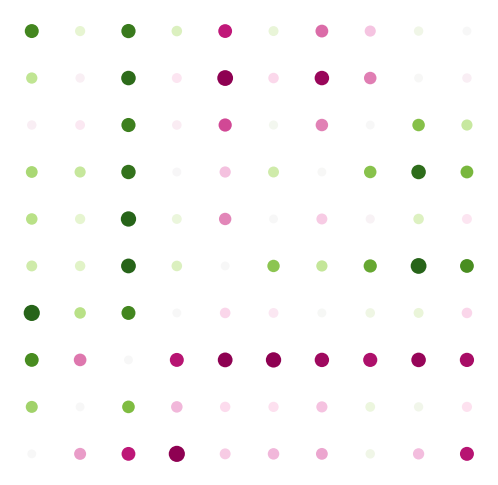

In [60]:
fc_asy_bins_inter = (fc_LR_bin - fc_RL_bin)#/(fc_LL_bin + fc_RR_bin)
df=pd.DataFrame()
matrix = np.arange(0, 100).reshape((10, 10)) % 10
df['x'] = matrix.flatten()
df['y'] = matrix.T.flatten()
df['color'] = fc_asy_bins_inter.flatten()
df['size'] = abs(fc_asy_bins_inter).flatten()
sns.relplot(data=df, x='x', y='y',hue='color', size='size', palette="PiYG_r",
            sizes=(40, 400), linewidth=0, legend=False,
            hue_norm=(-0.01, 0.01), size_norm=(0, 0.05),
            aspect=1, height=6)
plt.axis('off')
#plt.tight_layout()
plt.savefig('../figures/hcp/fc_inter_rankedbyai.png', dpi=300, transparent=True)

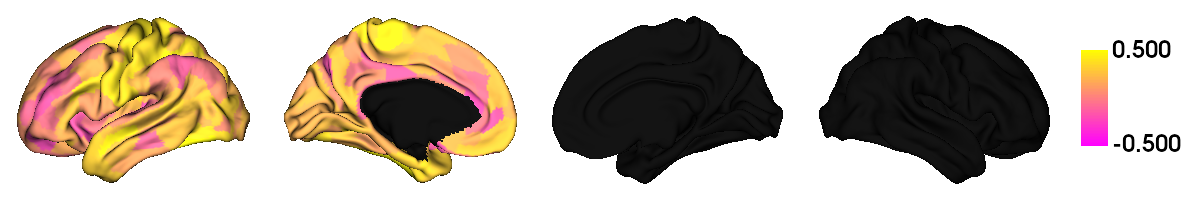

In [61]:
fc_asy = (fc_LL - fc_RR)#/(fc_LL + fc_RR)
fc_asy[np.isnan(fc_asy)] = 0
spatial_coup = np.zeros(180)
for i in range(180):
    spatial_coup[i] = ss.pearsonr(asy_total.mean(axis=0), fc_asy[i])[0]
np.savetxt('../hcp/hcp_asy_RegionWiseCoup.txt', spatial_coup)    
plot = map_to_labels(np.concatenate((spatial_coup,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.5,0.5),
                   cmap = 'spring', filename = '../figures/hcp/mean_func_asy_full.png')

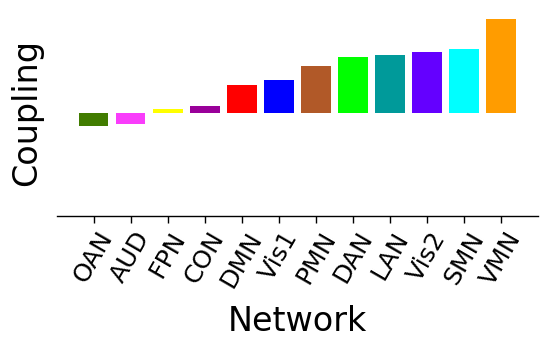

In [62]:
spatial_coup_ca = np.zeros(12)
for i in range(12):
    spatial_coup_ca[i] = spatial_coup[ca[:180] == i+1].mean()
np.savetxt('../hcp/hcp_asy_RegionWiseCoup_network.txt', spatial_coup_ca)        
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(6,4))
fp.plot_t_single(spatial_coup_ca, bar=None, ax=ax, thres=0.5, ascend=True, x_rota=60)
ax.set_xlabel('Network',labelpad=10)
ax.set_ylabel("Coupling", labelpad=10)
#ax.spines['left'].set_visible(True)
#ax.set_yticks([-0.5,0,0.5])
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/mean_func_asy_full_ca.png', dpi=300, transparent=True)

## Individual coupling

In [63]:
import os
sub = os.listdir('../hcp/func/FC/LL/')
sub.sort()
sub_list=[]
sub_func_LL=[]
sub_func_RR=[]
for i in sub:
    sub_list.append(int(i[:6]))
    sub_func_LL.append(np.loadtxt('../hcp/func/FC/LL/'+i, delimiter=','))
    sub_func_RR.append(np.loadtxt('../hcp/func/FC/RR/'+i, delimiter=','))
mask_func = np.zeros(1206)
for i in range(1206):
  if all_1206.ID[i] in sub_list:
      mask_func[i] = 1
#mask_func_struc = np.logical_and(mask_sub==1, mask_func==1)

In [64]:
indi_func_ll = np.array(sub_func_LL)[mask_sub[mask_func==1] == 1]
indi_func_rr = np.array(sub_func_RR)[mask_sub[mask_func==1] == 1]

indi_asy_func = indi_func_ll - indi_func_rr
indi_asy_struc = asy_total[mask_func[mask_sub==1] == 1]

### individual

In [65]:
indi_asy_func.shape

(1004, 180, 180)

In [66]:
indi_corr = np.zeros((indi_asy_func.shape[0],180)) # subject, spatial r
for i in range(indi_asy_func.shape[0]):
  for j in range(180):
    indi_corr[i,j] = ss.pearsonr(indi_asy_struc[i], indi_asy_func[i,j])[0]

In [67]:
indi_corr_ca =  np.zeros((indi_asy_func.shape[0],12))
for i in range(12):
    indi_corr_ca[:,i] = indi_corr[:,ca[:180] == i+1].mean(axis=1)
np.savetxt('../hcp/hcp_asy_RegionWiseCoup_IndividualMean.txt',indi_corr.mean(axis=0))
np.savetxt('../hcp/hcp_asy_RegionWiseCoup_IndividualSD.txt',indi_corr.std(axis=0))

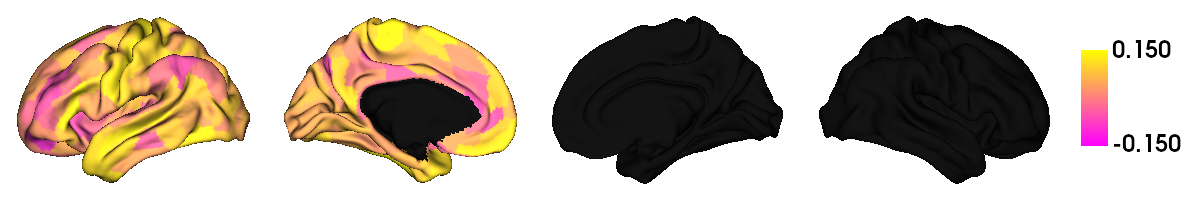

In [68]:
plot = map_to_labels(np.concatenate((indi_corr.mean(axis=0),np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.15,0.15),
                   cmap = 'spring', filename = '../figures/hcp/func_asy_full_indimean.png')

In [69]:
fs.spin_pearson(indi_corr.mean(axis=0), spatial_coup)

[PearsonRResult(statistic=0.9569820388169377, pvalue=1.3837505770569962e-97),
 0.0]

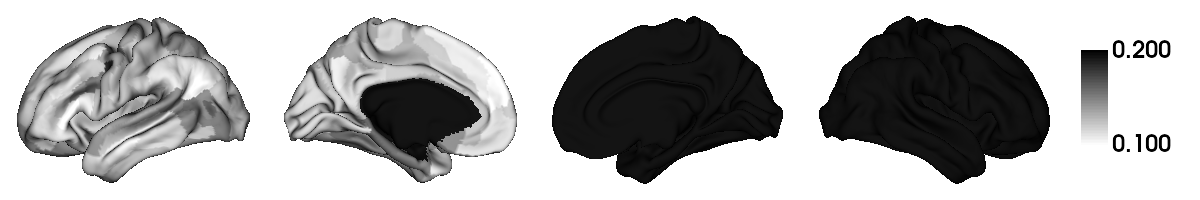

In [70]:
plot = map_to_labels(np.concatenate((indi_corr.std(axis=0),np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(0.1,0.2),
                   cmap = 'gray_r', filename = '../figures/hcp/func_asy_full_indistd.png')

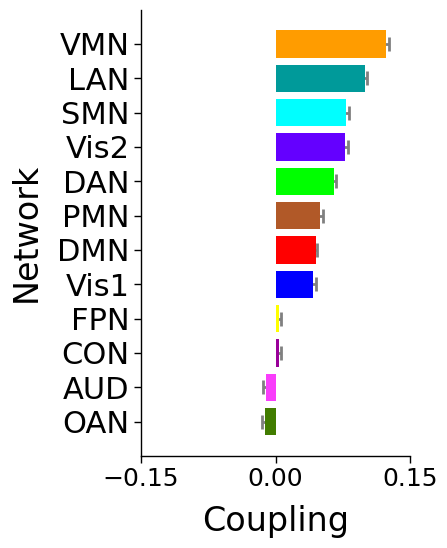

In [71]:
se = [fs.se(indi_corr_ca[:,i]) for i in range(12)]
np.savetxt('../hcp/hcp_asy_RegionWiseCoup_IndividualMean_network.txt',indi_corr_ca.mean(axis=0))
np.savetxt('../hcp/hcp_asy_RegionWiseCoup_IndividualSE_network.txt',se)
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(5,6))
fp.plot_t_single_h(indi_corr_ca.mean(axis=0), bar=np.array(se), ax=ax, thres=0.15, ascend=True, x_axis=True)
ax.set_ylabel('Network',labelpad=10)
ax.set_xlabel("Coupling", labelpad=10)
#ax.spines['left'].set_visible(True)
#ax.set_yticks([-0.5,0,0.5])
plt.xticks(fontsize=18)
fig.tight_layout()
fig.savefig('../figures/hcp/mean_func_asy_full_ca_indi.png', dpi=300, transparent=True)

### organization

In [72]:
indi_corr = np.zeros((180,180)) # struc, func
for i in range(180):
  for j in range(180):
    indi_corr[i,j] = ss.pearsonr(indi_asy_struc[:,i], indi_asy_func[:,i,j])[0]

np.savetxt('../hcp/hcp_asy_CoupOrganizationMatrix.txt',indi_corr_ca.mean(axis=0))

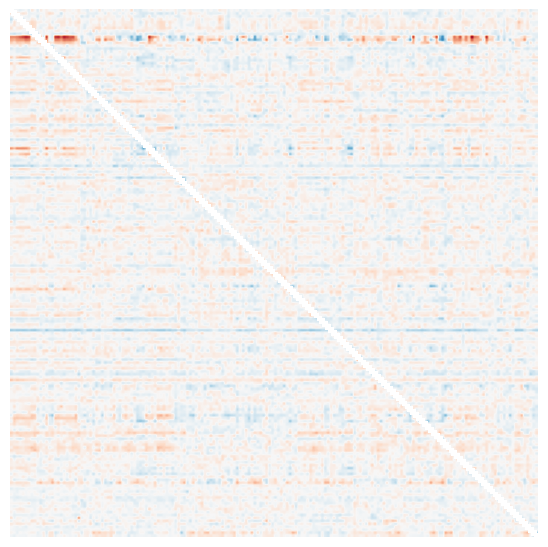

In [73]:
#indi_corr_z = np.arctanh(indi_corr)
#indi_corr[np.isnan(indi_corr)] = 0
#rank = indi_corr_z.mean(axis=1).argsort()
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(indi_corr, cmap='RdBu_r', vmax=0.5, vmin=-0.5)
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../figures/hcp/corr_struc_func_acrosssubjecs.png', dpi=300, transparent=True)

In [74]:
indi_corr[np.isnan(indi_corr)] = 0

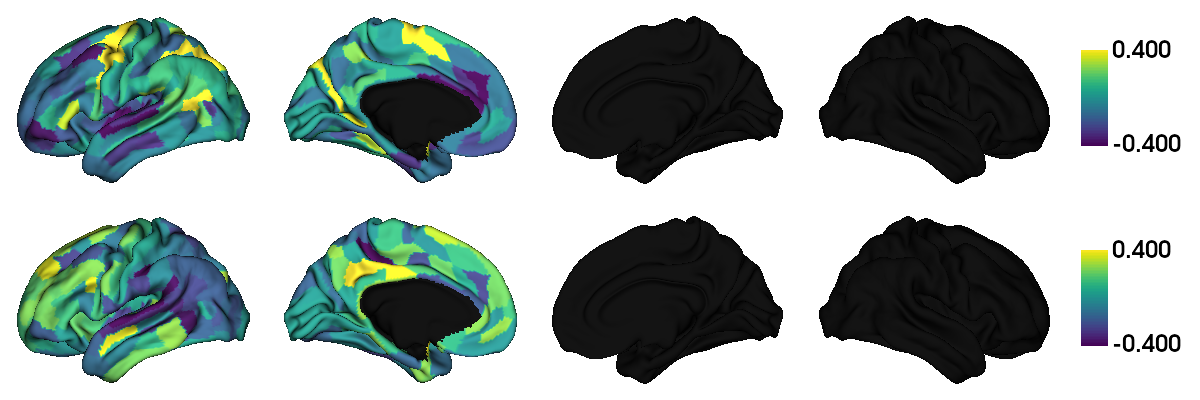

In [75]:
gm = GradientMaps(n_components=10, random_state=0, approach='pca', kernel='normalized_angle')
gm.fit(indi_corr, sparsity=0.9)

np.savetxt('../hcp/hcp_asy_CoupOrganizationPC_microstructure.txt',gm.gradients_[:,:2])

plot=[None]*2
for i in range(2): 
    plot[i] = map_to_labels(np.concatenate((gm.gradients_[:,i],np.zeros(180))), glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 400), color_range=(-0.4, 0.4),
                   cmap = 'viridis', filename = '../figures/hcp/hcp_struc_func_asy_covariance_row.png')

[0.26626013 0.17408371 0.16500044 0.08397745 0.07810886 0.05808062
 0.04977039 0.04351357 0.04123489 0.03996994]


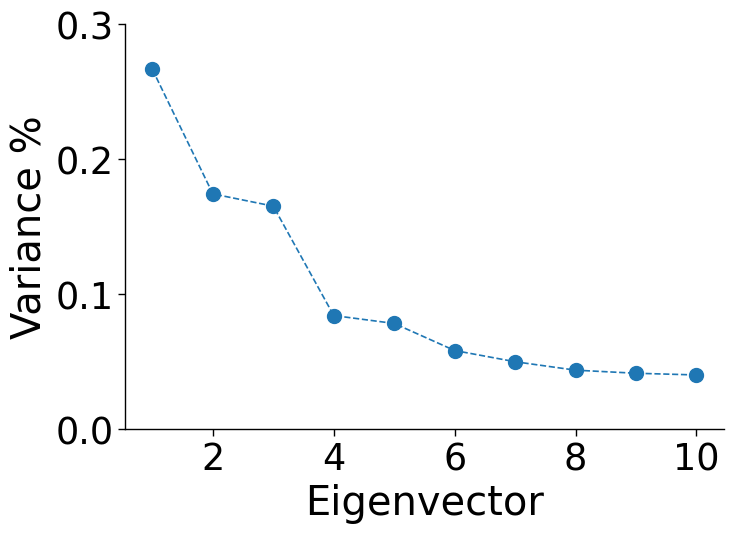

In [76]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(range(1,11), gm.lambdas_/np.sum(gm.lambdas_),'o', ms=10, ls='--')
#plt.plot(range(1,11), variance_ll/np.sum(variance_ll),c='darkblue')
plt.xlabel('Eigenvector')
plt.ylabel('Variance %')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.1, 0.2, 0.3])
plt.tight_layout()
plt.savefig('../figures/hcp/hcp_struc_func_asy_covariance_row_explain.png', dpi=300, transparent=True)
print(gm.lambdas_/np.sum(gm.lambdas_))

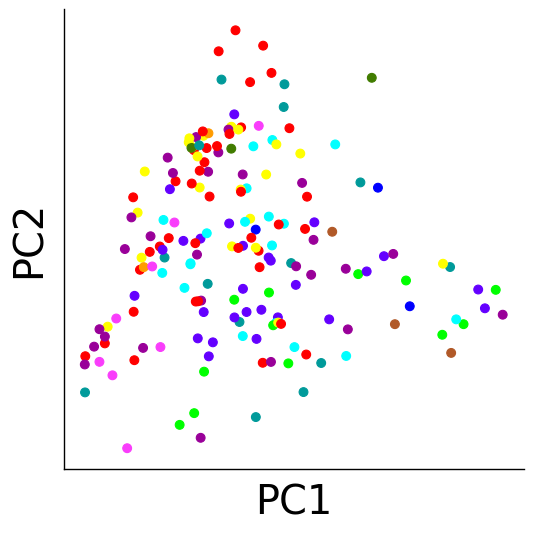

In [77]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(gm.gradients_[:,0], gm.gradients_[:,1], s = 40,  c = ca[:180], cmap=cmap, marker = 'o')
ax.set_xlabel('PC1',labelpad=10)
ax.set_ylabel('PC2',labelpad=10)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/hcp/hcp_struc_func_asy_covariance_row_2d.png', dpi=300, transparent=True)

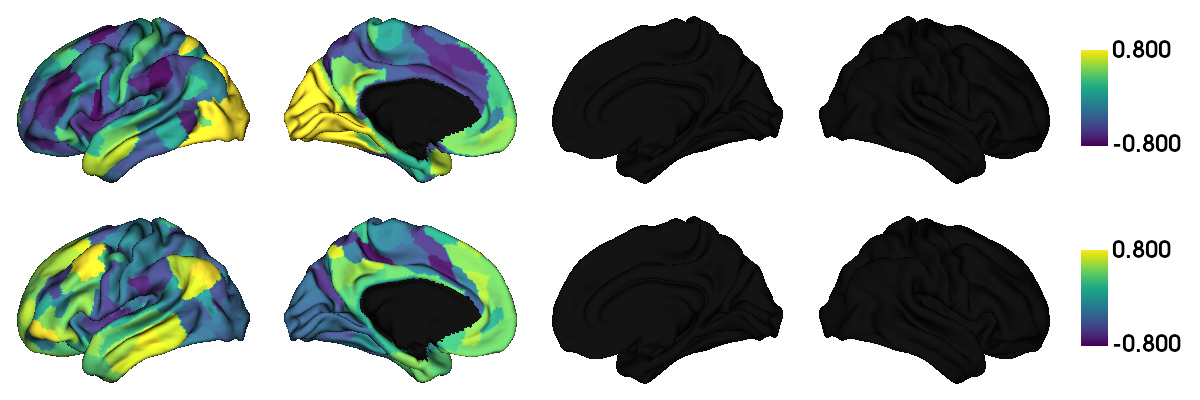

In [78]:
gm = GradientMaps(n_components=10, random_state=0, approach='pca', kernel='normalized_angle')
gm.fit(indi_corr.T, sparsity=0.9)

np.savetxt('../hcp/hcp_asy_CoupOrganizationPC_function.txt',gm.gradients_[:,:2])

plot=[None]*2
for i in range(2): 
    plot[i] = map_to_labels(np.concatenate((gm.gradients_[:,i],np.zeros(180))), glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 400), color_range=(-0.8,0.8),
                   cmap = 'viridis', filename = '../figures/hcp/hcp_struc_func_asy_covariance_col.png')

[0.48416925 0.25810574 0.10448544 0.03954452 0.03382833 0.02675395
 0.01693448 0.01571177 0.01048667 0.00997986]


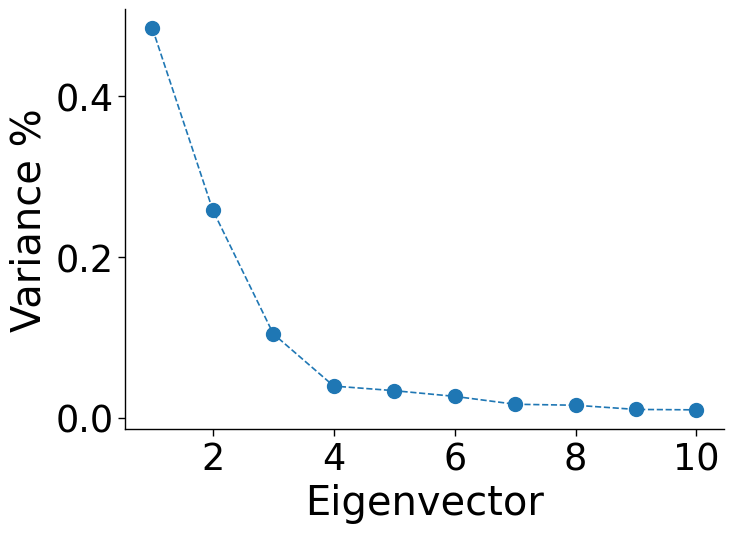

In [79]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(range(1,11), gm.lambdas_/np.sum(gm.lambdas_),'o', ms=10, ls='--')
#plt.plot(range(1,11), variance_ll/np.sum(variance_ll),c='darkblue')
plt.xlabel('Eigenvector')
plt.ylabel('Variance %')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.2, 0.4])
plt.tight_layout()
plt.savefig('../figures/hcp/hcp_struc_func_asy_covariance_col_explain.png', dpi=300, transparent=True)
print(gm.lambdas_/np.sum(gm.lambdas_))

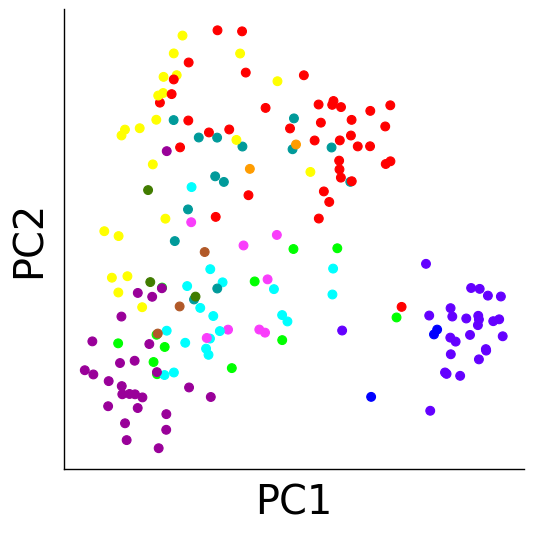

In [80]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(gm.gradients_[:,0], gm.gradients_[:,1], s = 40, c = ca[:180], cmap=cmap, marker = 'o')
ax.set_xlabel('PC1',labelpad=10)
ax.set_ylabel('PC2',labelpad=10)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../figures/hcp/hcp_struc_func_asy_covariance_col_2d.png', dpi=300, transparent=True)